In [77]:
import pandas as pd
import numpy as np
import quandl
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
import datetime
import pandas_datareader.data as web
from pandas import Series, DataFrame

In [2]:
register_matplotlib_converters()

In [74]:
stock_name = 'FSE/EON_X'

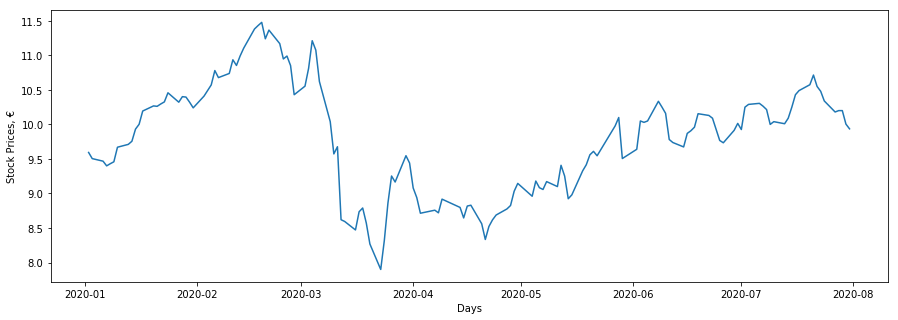

In [75]:
# Plot of E.ON(a big scale energy company in Europe)
# stock prices since beginning of 2019 (up to July)
prices = quandl.get(stock_name, 
                authtoken="", 
                start_date = '2020-01-01', end_date = '20-07-31'
                ).reset_index(drop = False)[['Date', 'Close']]
plt.figure(figsize = (15, 5))
plt.plot(prices['Date'], prices['Close'])
plt.xlabel('Days')
plt.ylabel('Stock Prices, €')
plt.show()

In [158]:
#--------------------------------------------------- GEOMETRIC BROWNIAN MOTION ------------------------------------------------

# Parameter Definitions

# So    :   initial stock price
# dt    :   time increment -> a day in our case
# T     :   length of the prediction time horizon(how many time points to predict, same unit with dt(days))
# N     :   number of time points in prediction the time horizon -> T/dt
# t     :   array for time points in the prediction time horizon [1, 2, 3, .. , N]
# mu    :   mean of historical daily returns
# sigma :   standard deviation of historical daily returns
# b     :   array for brownian increments
# W     :   array for brownian path

start_date = '2020-07-01'
end_date = '2020-07-31'
pred_end_date = '2020-08-31'

# We get daily closing stock prices of E.ON for July 2020
S_eon = quandl.get(stock_name, 
               authtoken="jqBD3HAqG-RmTY2cAgmZ", 
               start_date = start_date, end_date = end_date
               ).reset_index(drop = False)[['Date', 'Close']]

#Using scikit - different article
start = datetime.datetime(2020,7,1)
end = datetime.datetime(2020,7,31)
S_eon = web.DataReader("AAPL", 'yahoo', start, end).reset_index(drop = False)[['Date', 'Close']]
print(type(S_eon))

print(S_eon.head())
print(S_eon.tail())


<class 'pandas.core.frame.DataFrame'>
        Date      Close
0 2020-07-01  91.027496
1 2020-07-02  91.027496
2 2020-07-06  93.462502
3 2020-07-07  93.172501
4 2020-07-08  95.342499
         Date       Close
17 2020-07-27   94.809998
18 2020-07-28   93.252502
19 2020-07-29   95.040001
20 2020-07-30   96.190002
21 2020-07-31  106.260002


In [159]:
returns = (S_eon.loc[1:, 'Close'] - \
           S_eon.shift(1).loc[1:, 'Close']) / \
           S_eon.shift(1).loc[1:, 'Close']
print(returns.tolist())

[0.0, 0.026750215989129637, -0.0031028584811315495, 0.02329011408656154, 0.004300324276778921, 0.001749256920377178, -0.0046131908034296645, 0.016548420475024545, 0.006877322295030602, -0.012304931270650013, -0.0020202512022980544, 0.021073927924625677, -0.013801674444927262, 0.00280926891208924, -0.04551643995416049, -0.002477283148360886, 0.023700261787544568, -0.016427540948146833, 0.01916837004180387, 0.012100184288729552, 0.10468863124271484]


In [160]:
# Parameter Assignments
So = S_eon.loc[S_eon.shape[0] - 1, "Close"]
dt = 1 # day   # User input
n_of_wkdays = pd.date_range(start = pd.to_datetime(end_date, 
                 format = "%Y-%m-%d") + pd.Timedelta('1 days'), 
                 end = pd.to_datetime(pred_end_date, 
                 format = "%Y-%m-%d")).to_series().map(lambda x: 
                 1 if x.isoweekday() in range(1,6) else 0).sum()
T = n_of_wkdays # days  # User input -> follows from pred_end_date
N = T / dt
t = np.arange(1, int(N) + 1)
mu = np.mean(returns)
sigma = np.std(returns)
scen_size = 50 # User input
b = {str(scen): np.random.normal(0, 1, int(N)) for scen in range(1, scen_size + 1)}
W = {str(scen): b[str(scen)].cumsum() for scen in range(1, scen_size + 1)}


In [161]:
# Calculating drift and diffusion components
drift = (mu - 0.5 * sigma**2) * t
print(drift)
diffusion = {str(scen): sigma * W[str(scen)] for scen in range(1, scen_size + 1)}
print(diffusion)

[0.00738175 0.01476351 0.02214526 0.02952701 0.03690877 0.04429052
 0.05167227 0.05905402 0.06643578 0.07381753 0.08119928 0.08858104
 0.09596279 0.10334454 0.1107263  0.11810805 0.1254898  0.13287155
 0.14025331 0.14763506 0.15501681]
{'1': array([-0.00824586,  0.01134499, -0.00150007, -0.05486049, -0.04580824,
       -0.05548667, -0.04453566, -0.07224341, -0.08332204, -0.16391592,
       -0.15751477, -0.15403395, -0.0828035 , -0.11261782, -0.12890793,
       -0.1115556 , -0.16002826, -0.14331389, -0.16527624, -0.14496657,
       -0.10219734]), '2': array([ 0.00980517, -0.0315727 , -0.04572354, -0.0398517 , -0.08198047,
       -0.0765832 , -0.07956533, -0.1043443 , -0.09315124, -0.10948115,
       -0.10466986, -0.09775926, -0.07596134, -0.13352974, -0.134955  ,
       -0.10193851, -0.13666277, -0.14895216, -0.15849755, -0.15932312,
       -0.14774049]), '3': array([0.03356023, 0.07224783, 0.09259207, 0.10292074, 0.08401335,
       0.06983021, 0.08540622, 0.08465593, 0.10702144, 0.0793

In [162]:
# Making the predictions
S = np.array([So * np.exp(drift + diffusion[str(scen)]) for scen in range(1, scen_size + 1)]) 
S = np.hstack((np.array([[So] for scen in range(scen_size)]), S)) # add So to the beginning series
print(S)

[[106.26000214 106.16822208 109.07082396 ... 103.63405712 106.54393408
  112.02347102]
 [106.26000214 108.10206907 104.48878476 ... 104.33894645 105.02525933
  107.03600438]
 [106.26000214 110.70078407 115.91999736 ... 131.98744087 132.06902208
  128.54996033]
 ...
 [106.26000214 109.72588002 114.24976944 ... 140.48633839 141.11732908
  143.49546712]
 [106.26000214 102.59745181 103.06449888 ... 108.80149561 108.236311
  105.77786093]
 [106.26000214 105.97664263 104.05335076 ... 104.72087442 104.69034018
  103.10646943]]


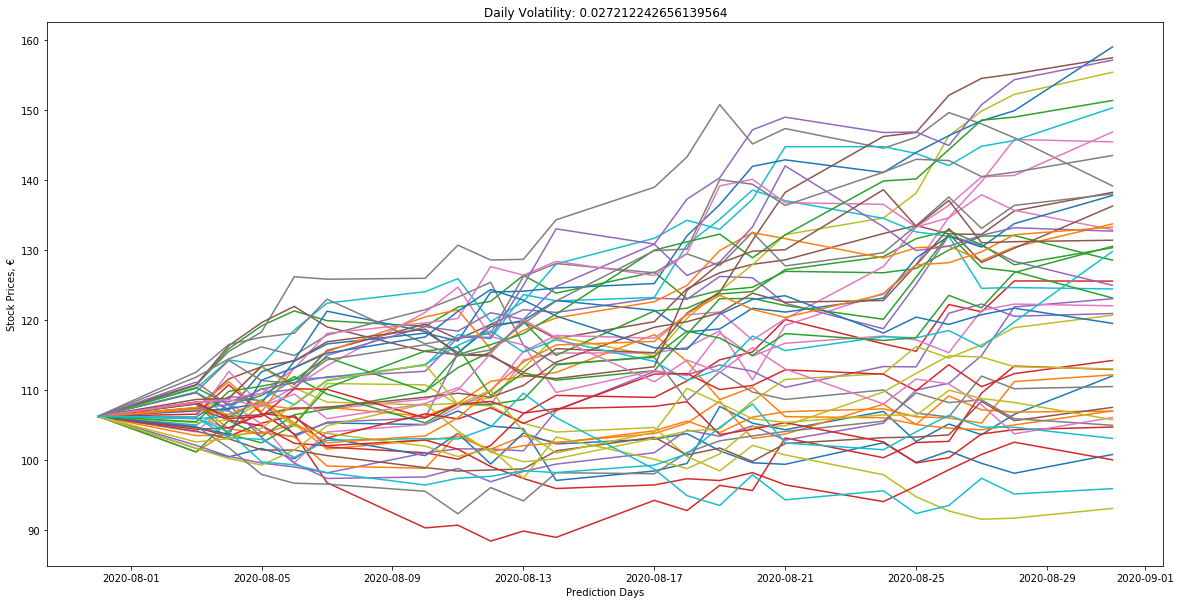

In [163]:
# Plotting the simulations
plt.figure(figsize = (20,10))
for i in range(scen_size):
    plt.title("Daily Volatility: " + str(sigma))
    plt.plot(pd.date_range(start = S_eon["Date"].max(), 
                end = pred_end_date, freq = 'D').map(lambda x:
                x if x.isoweekday() in range(1, 6) else np.nan).dropna(), S[i, :])
    plt.ylabel('Stock Prices, €')
    plt.xlabel('Prediction Days')
plt.show()

In [164]:
# Dataframe format for predictions - first 10 scenarios only
Preds_df = pd.DataFrame(S.swapaxes(0, 1)[:, :10]).set_index(
           pd.date_range(start = S_eon["Date"].max(), 
           end = pred_end_date, freq = 'D').map(lambda x:
           x if x.isoweekday() in range(1, 6) else np.nan).dropna()
           ).reset_index(drop = False)

In [165]:
def maxProfit (k, prices):
    # corner case
    if prices is None or len(prices) == 0: return 0
    # if k is too large, to save space, we can directly sum up profit pair by pair
    if 2*k >= len(prices): 
        return sum(max(0, prices[i]-prices[i-1]) for i in range(1, len(prices)))

    # optimized DP solution in problem III by using two rows instead of a matrix 
    n = len(prices)
    no_of_transaction = 0
    currProfit = [0 for _ in range(n)]
    prevProfit = [0 for _ in range(n)]
    for i in range(1, k+1):
        maxdiff = -prices[0]
        # assign currProfit array [last loop] to prevProfit array [this loop]
        # 1. also create an new currProfit array for futher use [easy to understand] 
        currProfit, prevProfit = [0 for _ in range(n)], currProfit
        # 2. assign prevProfit array to currprofit since currProfit[0] is still zero, which is enough here [Faster way] 
        # currProfit, prevProfit = prevProfit, currProfit
        for j in range(1, n):
            currProfit[j] = max(currProfit[j-1], prices[j]+maxdiff)
            maxdiff = max(maxdiff, prevProfit[j]-prices[j])  
        print(str(currProfit[-1]))
    # return the result
    return currProfit[-1]

In [166]:
max_profit = 0
for i in range(len(S)):
    max_profit = max(max_profit, maxProfit(10, S[i]))
    
print(max_profit)

14.918696199892167
19.933645010473185
23.35281720995077
26.25541909554707
28.868491354076383
30.390607499405448
30.63221318960464
30.63221318960464
30.63221318960464
30.63221318960464
6.851942418257963
11.743637248457972
14.440695184582694
16.28276211819842
18.04279134675211
19.427456664618532
20.349092308643847
20.349092308643847
20.349092308643847
20.349092308643847
25.809019939808422
29.603158532191642
32.14288687830896
34.34586065569391
34.54603205510239
34.54603205510239
34.54603205510239
34.54603205510239
34.54603205510239
34.54603205510239
25.450321426354037
29.98608435051878
32.94811092332577
33.98562212398784
34.27858992729681
34.27858992729681
34.27858992729681
34.27858992729681
34.27858992729681
34.27858992729681
28.73572250352386
36.206914341330986
37.34272847108198
37.73651320496862
37.888962071928944
37.888962071928944
37.888962071928944
37.888962071928944
37.888962071928944
37.888962071928944
31.979261872693343
34.492938083507
36.88367169715518
39.034849941500994
40.3044

In [167]:
def single_profit(kind, prices):
    n = len(prices)
    if n == 0:
        return 0
    temp = 0
    result = 0
    tempSell = 0
    maxPrice = prices[n - 1]
    
    buyDates = []
    sellDates = []
    buy_date = 0
    sell_date = 0
    
    for i in range(n-2, -1, -1):
        if prices[i] < maxPrice:
            result = max(result, maxPrice- prices[i])
            if result != temp:
                buyDates.append(i)
            temp = result
        
        maxPrice = max(maxPrice, prices[i])
        if maxPrice != tempSell:
            sellDates.append(i)
        tempSell = maxPrice
    
    if len(buyDates) > 0:
        buy_date = buyDates[len(buyDates) - 1]
#         print("Buy on day " + str(buyDates[len(buyDates) - 1]))
    
    if len(sellDates) > 0:
        i = 1
        if kind == "max":
            if sellDates[len(sellDates) - 1] < buyDates[len(buyDates) - 1]:
                sell_date = sellDates[len(sellDates) - 2]
    #             print("Sell on sell " + str(sellDates[len(sellDates) - 2]))
            else:
                sell_date = sellDates[len(sellDates) - 1]
    #             print("Sell on sell " + str(sellDates[len(sellDates) - 1]))
        else:
            while sellDates[len(sellDates) - i] < buyDates[len(buyDates) - 1]:
                sell_date = sellDates[len(sellDates) - i - 1]
                i = i + 1
    
    return result, buy_date, sell_date


In [156]:
max_profit = 0
buy_date = 0
sell_date = 0
min_profit = 100000000000

#Best case scenario
for i in range(len(S)):
    temp_profit, temp_buy, temp_sell = single_profit("max", S[i])
#     max_profit = max(max_profit, single_profit(S[i]))
    if(temp_profit > max_profit):
        max_profit = temp_profit
        buy_date = temp_buy
        sell_date = temp_sell
    
print(max_profit)
print("Buy on " + str(buy_date))
print("Sell on " + str(sell_date))

#Worst case scenario
for i in range(len(S)):
    temp_profit, temp_buy, temp_sell = single_profit("min", S[i])
#     max_profit = max(max_profit, single_profit(S[i]))
    if(temp_profit < min_profit):
        min_profit = temp_profit
        buy_date = temp_buy
        sell_date = temp_sell
        
print(min_profit)
print("Buy on " + str(buy_date))
print("Sell on " + str(sell_date))


3.74767333560451
Buy on 0
Sell on 18
0.2799934595468514
Buy on 5
Sell on 9
